In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import astropy.stats
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
import astropy.io.fits as fits
from astropy.modeling import models, fitting

from scipy.signal import medfilt
import scipy
import matplotlib.lines as mlines

import os, shutil
import itertools as it

from palettable.tableau import Tableau_10
col = Tableau_10.hex_colors

from binotools import calbino
import binotools as bt

plt.style.use('seaborn-talk')
from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

plt.rc('figure', dpi=150, figsize=(5,5))

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Flux calibrate each frame

- Find stars on mask
- Extract star spectra from 2D spec
- Calculate PSF
- Calibrate each star
- Find median calibration
- Calibrate frame
- Check star is good

In [5]:
# Init flux cal
fluxcal = calbino.FluxCalBino()

# Find the stars

In [1]:
slits = pd.read_csv(os.environ['BINO_DIR']+'2649_BLAS_1/masks/BLAS_1_slits.csv')

# fits file ext # = slits.index + 1
slits['extnum'] = slits.index + 1

stars = slits[slits.type == 'STANDARD']

# Find star mags
mags_all = []
for i in range(len(stars)):
    fluxcal.get_star_mags(stars.iloc[i].ra, stars.iloc[i].dec, verbose=False)
    star_mags = fluxcal.star_mags
    mags_all.append(star_mags)
    
stars['mags'] = mags_all
stars

NameError: name 'pd' is not defined

# Get data

In [7]:
# New
datadir = os.environ['BINO_DIR']+'SAO-9/individual_frames/'

spec2D_all = sorted(bt.insensitive_glob(datadir+'/*/*/reduced_series/obj_clean*abs_slits_lin.fits'))
print(len(spec2D_all))
nights = np.array([s.split('individual_frames/')[-1].split('/')[0] for s in spec2D_all])

# Old
# datadir = os.environ['BINO_DIR']+'SAO-9/'

# spec2D_all = sorted(bt.insensitive_glob(datadir+'/*/reduced/*/obj_clean*abs_slits_lin.fits'))
# nights = np.array([s.split('reduced/')[-1].split('/')[0] for s in spec2D_all])

nights = np.unique(nights)
nights

63


array(['2019.0208', '2019.0212', '2019.0329', '2019.0331', '2019.0404',
       '2019.0525', '2019.0526', '2019.0601', '2019.0602', '2019.0603',
       '2019.0628', '2019.0704', '2019.0709'], dtype='<U9')

In [8]:
wave_A = bt.get_wave_A_from_spec2D(spec2D_all[0])

# Extract 1D spectra and psf

## On each frame

In [9]:
spec2D_file = spec2D_all[0]
spec2D_hdu  = fits.open(spec2D_file)

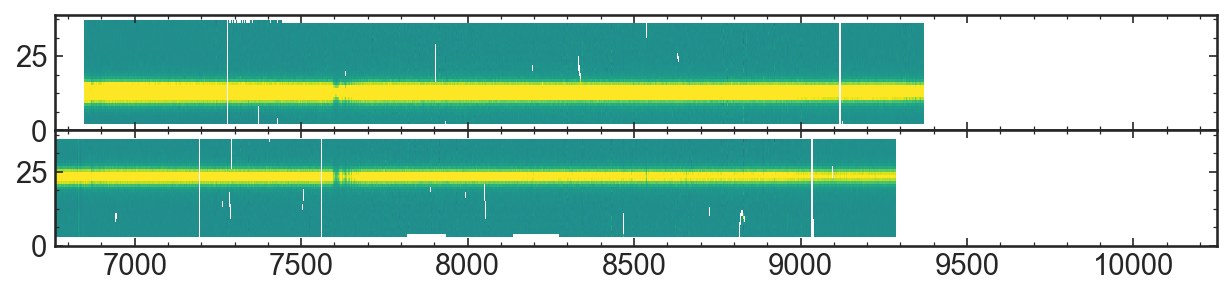

In [10]:
fig, ax = plt.subplots(2,1, figsize=(10,2), dpi=150, sharex=True)
vmin, vmax = -10, 10
# vmin, vmax = -5, 5
# Each star
for i in range(2):
    spec2D_star = spec2D_hdu[stars.index[i]+1].data

    ax[i].imshow(spec2D_star, vmin=vmin, vmax=vmax, aspect='auto',
                   extent=[wave_A.min(), wave_A.max(), 0., spec2D_star.shape[0]])

fig.subplots_adjust(hspace=0.)
# plt.savefig('2019.0208_BLAS_1a_600_8500_reduced_series_obj_clean000_abs_slits_lin.png')
# plt.savefig('BLAS_1a_reduced_2019.0208_obj_clean000_abs_slits_lin.fits.png')

0.9268995940936373


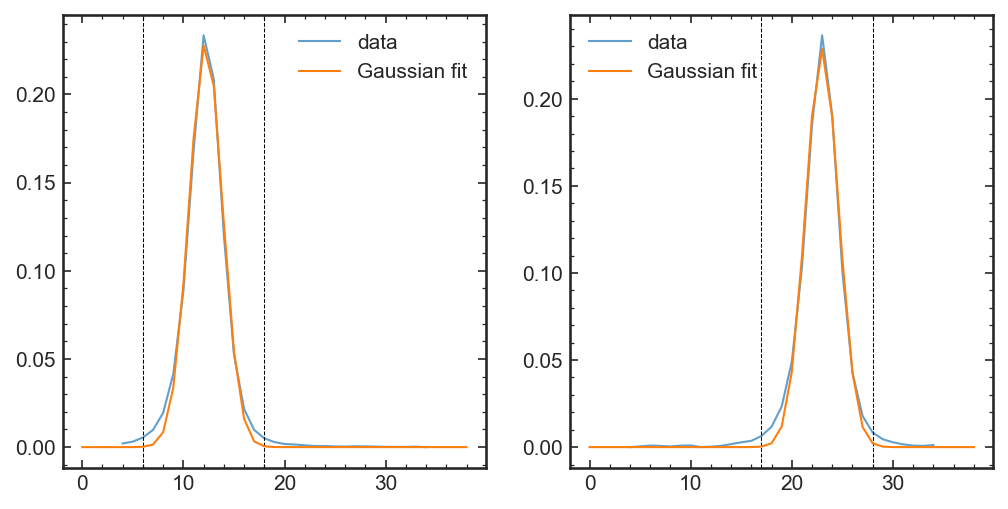

In [43]:
fig_psf, ax_psf = plt.subplots(1,2, figsize=(8,4), dpi=150)
ax_psf = ax_psf.ravel()

# Each star
seeing_FWHM_arcsec = []
for i in range(2):
    spec2D_star = spec2D_hdu[stars.index[i]+1].data
    spec1D_star_eachframe, FWHM_pix = bt.extract1D_psf(spec2D_star, psf_lim=0.02, plot_psf=True, ax=ax_psf[i])
    seeing_FWHM_arcsec.append(FWHM_pix * bt.arcsec_per_px)
    
seeing_FWHM_arcsec_med = np.median(np.array(seeing_FWHM_arcsec))
print(seeing_FWHM_arcsec_med)

# Flux calibration

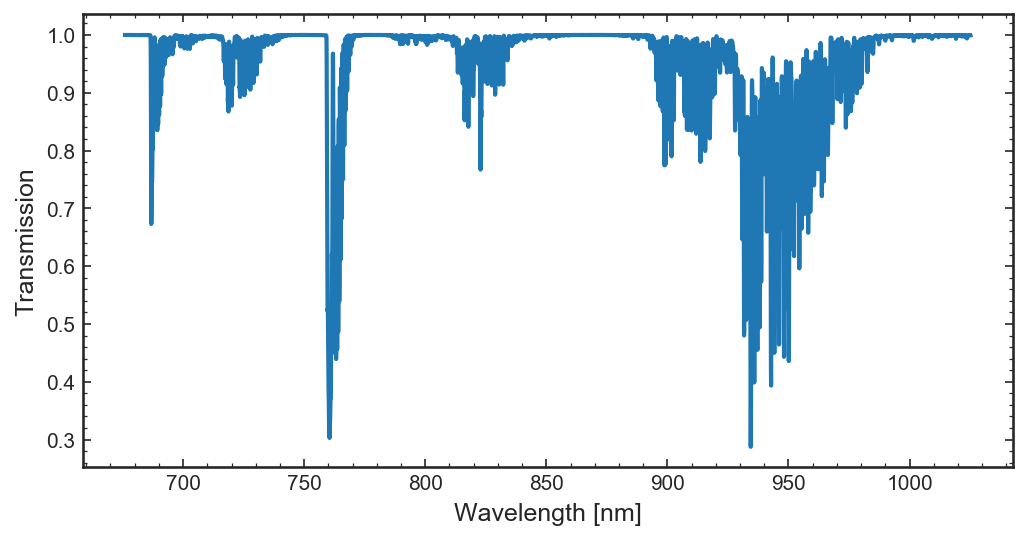

In [10]:
tellcorr = bt.TelluricCorrection(plot=True)

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


Text(0, 0.5, 'Calibration')

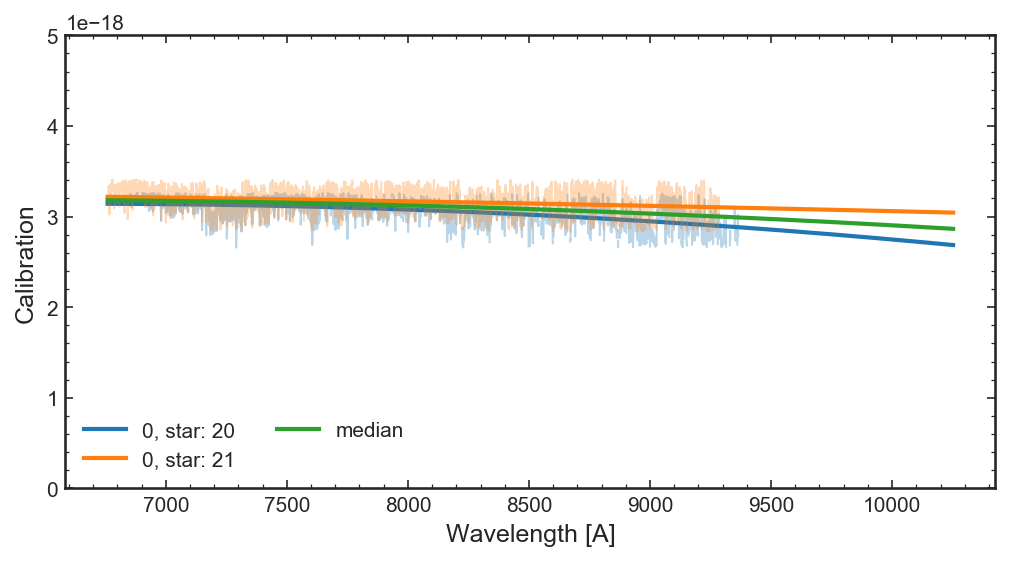

In [12]:
tell_corr  = True
cut_badpix = 95.

# Frame ID
frame = int(spec2D_file.split('clean')[-1].split('_')[0])

fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150)

# Each star
polyfitted_calibration_allstars = np.zeros((len(stars),len(wave_A)))
for i in range(len(stars)):
    fluxcal.star_mags = stars.iloc[i]['mags']
    
    spec2D_star = spec2D_hdu[stars.index[i]+1].data
    
    # Get 1D spectrum
    spec1D_star_eachframe, FWHM_pix = bt.extract1D_psf(spec2D_star, psf_lim=0.02, plot_psf=False, ax=None)
    spec1D_star_eachframe[spec1D_star_eachframe == 0.] = np.nan
    
    # Do telluric correction
    if tell_corr:
        spec1D_star_eachframe = tellcorr.optimized_tellcorr(wave_A, spec1D_star_eachframe)

    # Calibration
    calibration = fluxcal.flux_calibration(spec1D_star_eachframe, wave_A)

    # Filter bad pixels
    low, high = np.nanpercentile(calibration, 100-cut_badpix), np.nanpercentile(calibration, cut_badpix)
    calibration[np.where((calibration < low) | (calibration > high))] = np.nan
    
    # Smooth calibration
    polyfitted_calibration_allstars[i] = fluxcal.smooth_calibration(wave_A, calibration, degree=2)

    # Plot
    ln = ax.plot(wave_A, calibration, lw=1, alpha=0.3)
    ax.plot(wave_A, polyfitted_calibration_allstars[i], c=ln[0].get_color(), lw=2, alpha=1, label='%i, star: %i' % (frame, stars.iloc[i]['extnum']))
    
polyfitted_calibration_median = np.nanmedian(polyfitted_calibration_allstars, axis=0)
plt.plot(wave_A, polyfitted_calibration_median, label='median')

ax.set_ylim(-0., 5e-18)

ax.legend(loc='lower left', ncol=2, frameon=True)
ax.set_xlabel('Wavelength [A]')
ax.set_ylabel('Calibration')

In [58]:
print(polyfitted_calibration_allstars)
df = pd.DataFrame(data= np.zeros((len(spec2D_all),len(wave_A))).T, columns=spec2D_all)
df['wave_A'] = wave_A

df

[[3.14130519e-18 3.14130040e-18 3.14129558e-18 ... 2.68606263e-18
  2.68590565e-18 2.68574864e-18]
 [3.21922738e-18 3.21920531e-18 3.21918323e-18 ... 3.04393820e-18
  3.04389799e-18 3.04385777e-18]]


,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/obj_clean000_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/obj_clean001_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/obj_clean002_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/obj_clean003_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/obj_clean004_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/obj_clean005_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/obj_clean006_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/obj_clean007_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0212/obj_clean000_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0212/obj_clean001_abs_slits_lin.fits,...,/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0329/obj_clean003_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1b/reduced/2019.0331/obj_clean000_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1b/reduced/2019.0331/obj_clean001_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1b/reduced/2019.0331/obj_clean002_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1b/reduced/2019.0331/obj_clean003_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1c/reduced/2019.0404/obj_clean000_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1c/reduced/2019.0404/obj_clean001_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1c/reduced/2019.0404/obj_clean002_abs_slits_lin.fits,/h/hobnob0/Binospec/SAO-9/BLAS_1c/reduced/2019.0404/obj_clean003_abs_slits_lin.fits,wave_A
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6760.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6760.620110
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6761.240220
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6761.860330
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6762.480440
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6763.100551
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6763.720661
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6764.340771
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6764.960881
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6765.580991


## Plot Calibration

In [11]:
calib = pd.read_csv('/h/hobnob0/Binospec/SAO-9/individual_frames/calibration_frames.txt', sep='\t')

Text(0.5, 0, 'Wavelength [A]')

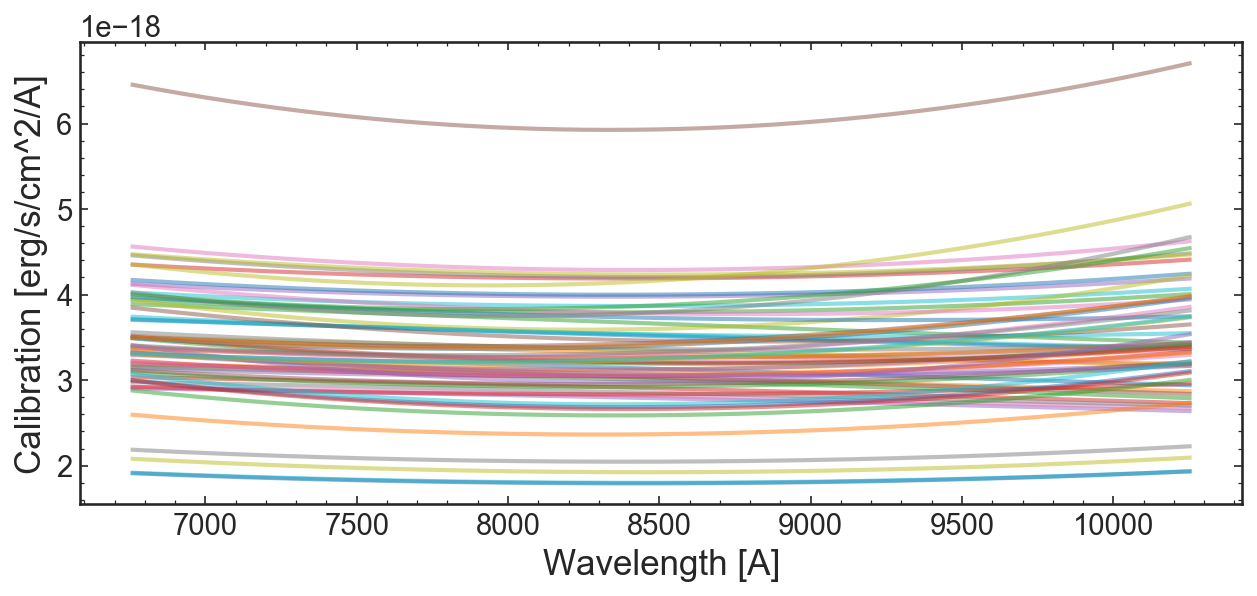

In [12]:
plt.figure(figsize=(10, 4))
for frame in calib.columns[:-1]:
    plt.plot(calib.wave_A, calib[frame], lw=2, alpha=0.5)
    
plt.ylabel('Calibration [erg/s/cm^2/A]')
plt.xlabel('Wavelength [A]')

'2019-11-05T11:22:41'